In [1]:
import mxnet as mx

In [5]:
import os, urllib
def download(url):
    filename = url.split("/")[-1]
    if not os.path.exists(filename):
        urllib.urlretrieve(url, filename)

In [46]:
def get_iterators(batch_size, data_shape=(3, 224, 224)):
    train = mx.io.ImageRecordIter(
        path_imgrec         = '../data/facesqueeze-train.rec',
        data_name           = 'data',
        label_name          = 'softmax_label',
        batch_size          = batch_size,
        data_shape          = data_shape,
        shuffle             = True,
        rand_crop           = True,
        rotate              = 15,
        rand_mirror         = True)
    val = mx.io.ImageRecordIter(
        path_imgrec         = '../data/facesqueeze-val.rec',
        data_name           = 'data',
        label_name          = 'softmax_label',
        batch_size          = batch_size,
        data_shape          = data_shape,
        rand_crop           = False,
        rand_mirror         = False)
    return (train, val)

In [3]:
def get_model(prefix, epoch):
    download(prefix+'-symbol.json')
    download(prefix+'-%04d.params' % (epoch,))

In [19]:
get_model('http://data.mxnet.io/models/imagenet/squeezenet/squeezenet_v1.1', 0)

In [20]:
sym, arg_params, aux_params = mx.model.load_checkpoint('squeezenet_v1.1', 0)

In [47]:
def get_fine_tune_model(symbol, arg_params, num_classes, layer_name='flatten0'):
    """
    symbol: the pretrained network symbol
    arg_params: the argument parameters of the pretrained model
    num_classes: the number of classes for the fine-tune datasets
    layer_name: the layer name before the last fully-connected layer
    """
    all_layers = symbol.get_internals()
    net = all_layers[layer_name+'_output']
    net = mx.symbol.FullyConnected(data=net, num_hidden=num_classes, name='fc1')
    net = mx.symbol.SoftmaxOutput(data=net, name='softmax')
    new_args = dict({k:arg_params[k] for k in arg_params if 'fc1' not in k})
    return (net, new_args)

In [48]:
import logging
head = '%(asctime)-15s %(message)s'
logging.basicConfig(level=logging.DEBUG, format=head)

def fit(symbol, arg_params, aux_params, train, val, batch_size, num_gpus, num_epochs=8):
    devs = [mx.gpu(i) for i in range(num_gpus)]
    mod = mx.mod.Module(symbol=symbol, context=devs)
    mod.fit(train, val,
        num_epoch=num_epochs,
        arg_params=arg_params,
        aux_params=aux_params,
        allow_missing=True,
        batch_end_callback = mx.callback.Speedometer(batch_size, 10),
        kvstore='device',
        optimizer='adam',
        epoch_end_callback=mx.callback.do_checkpoint('models/facesqueeze'),
        optimizer_params={'learning_rate':0.001},
        initializer=mx.init.Xavier(rnd_type='gaussian', factor_type="in", magnitude=2),
        eval_metric='acc')
    metric = mx.metric.Accuracy()
    return mod.score(val, metric)

In [49]:
num_classes = 2
batch_per_gpu = 16
num_gpus = 1

(new_sym, new_args) = get_fine_tune_model(sym, arg_params, num_classes, 'flatten')

batch_size = batch_per_gpu * num_gpus
(train, val) = get_iterators(batch_size)
mod_score = fit(new_sym, new_args, aux_params, train, val, batch_size, num_gpus, 1)
assert mod_score > 0.77, "Low training accuracy."

2017-10-11 17:15:24,763 Epoch[0] Batch [10]	Speed: 198.18 samples/sec	accuracy=0.846591
2017-10-11 17:15:25,464 Epoch[0] Batch [20]	Speed: 228.67 samples/sec	accuracy=0.962500
2017-10-11 17:15:26,170 Epoch[0] Batch [30]	Speed: 227.06 samples/sec	accuracy=0.968750
2017-10-11 17:15:26,873 Epoch[0] Batch [40]	Speed: 228.06 samples/sec	accuracy=0.943750
2017-10-11 17:15:27,579 Epoch[0] Batch [50]	Speed: 227.16 samples/sec	accuracy=0.893750
2017-10-11 17:15:28,286 Epoch[0] Batch [60]	Speed: 226.66 samples/sec	accuracy=0.925000
2017-10-11 17:15:28,994 Epoch[0] Batch [70]	Speed: 227.98 samples/sec	accuracy=0.931250
2017-10-11 17:15:30,948 Epoch[0] Batch [80]	Speed: 82.04 samples/sec	accuracy=0.937500
2017-10-11 17:15:31,649 Epoch[0] Batch [90]	Speed: 229.26 samples/sec	accuracy=0.956250
2017-10-11 17:15:32,350 Epoch[0] Batch [100]	Speed: 228.66 samples/sec	accuracy=0.931250
2017-10-11 17:15:33,051 Epoch[0] Batch [110]	Speed: 229.03 samples/sec	accuracy=0.925000
2017-10-11 17:15:33,752 Epoch[0

In [50]:
model_loaded = mx.mod.Module.load('models/facesqueeze', 1)

In [51]:
print model_loaded

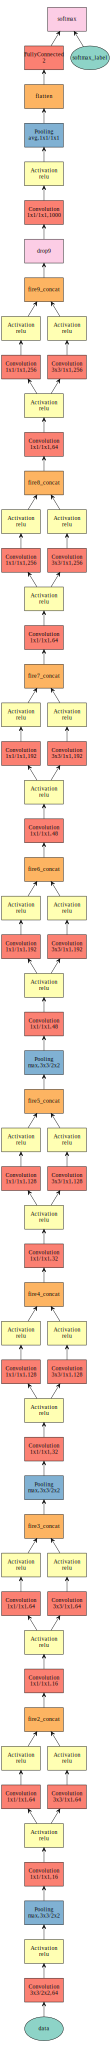

In [53]:
mx.viz.plot_network(new_sym)

## Evaluate
Ok. So we have 98.40% accuracy on our validation set. Now let's see how our model performs with images pulled from the internet.

In [2]:
import mxnet as mx

model_loaded = mx.mod.Module.load('models/facesqueeze', 1)
model_loaded.bind(for_training=False, data_shapes= [('data', (1,3,224,224))])

/Users/nickrobi/.virtualenvs/reinvent/lib/python2.7/site-packages/mxnet/module/base_module.py:65: UserWarning: Data provided by label_shapes don't match names specified by label_names ([] vs. ['softmax_label'])
  warnings.warn(msg)


In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time

from collections import namedtuple
Batch = namedtuple('Batch', ['data'])

reshape=(224, 224)

/Users/nickrobi/.virtualenvs/reinvent/lib/python2.7/site-packages/matplotlib/font_manager.py:279: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [5]:
filename = '../examples/george_bush.jpg'

img = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)

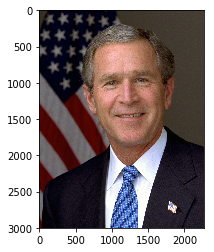

In [6]:
plt.imshow(img)

In [7]:
# Run forward on the image
# Resize image to fit network input
start_time = time.time()
img = cv2.resize(img, reshape)
img = np.swapaxes(img, 0, 2)
img = np.swapaxes(img, 1, 2)
img = img[np.newaxis, :]



model_loaded.forward(Batch([mx.nd.array(img)]))
prob = model_loaded.get_outputs()[0].asnumpy()
prob = np.squeeze(prob)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0463259220123 seconds ---


In [9]:
prob

array([  9.99988794e-01,   1.11481868e-05], dtype=float32)

In [10]:
filename = '../examples/condoleezza_rice.jpg'
img = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)

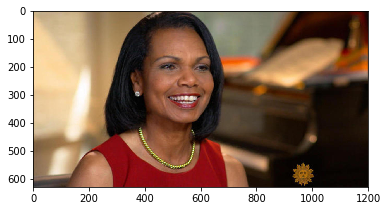

In [11]:
plt.imshow(img)

In [12]:
# Run forward on the image
# Resize image to fit network input
start_time = time.time()
img = cv2.resize(img, reshape)
img = np.swapaxes(img, 0, 2)
img = np.swapaxes(img, 1, 2)
img = img[np.newaxis, :]



model_loaded.forward(Batch([mx.nd.array(img)]))
prob = model_loaded.get_outputs()[0].asnumpy()
prob = np.squeeze(prob)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0598978996277 seconds ---


In [13]:
prob

array([  1.00000000e+00,   2.21342259e-12], dtype=float32)